In [1]:
import numpy as np
import math
import copy 
import matplotlib.pylab as plt 
import seaborn as sns


In [2]:
class rcga:
    '''
    Twoja stara to petarda 
    '''
    def __init__(self,nConcepts,concepts,Pmutation=None,Precombination=None,population_size=None,max_generations=None,historicaldata=None,fcm=None,
                 numberofsteps=None,tournamentP=None,tournamentK=None,lbd=None ):
        
        # GENERAL PARAMS 
        # types of mutations are randomly choosen according to authors of the article W.Stach et al. 2005
        self.mutation_methods = ['random','nonuniform','Muhlenbein']
        # types of selection are randomly choosen according to authors of the article W.Stach et al. 2005
        self.selection_methods = ['rulette','tournament']
        # proability of cell mutatiing 
        self.prob_mutation = 0.5 if Pmutation is None else Pmutation
        self.prob_recombination = 0.9 if Precombination is None else Precombination
        self.tournamentP = 1 if tournamentP is None else tournamentP
        self.tournamentK = 5 if tournamentK is None else tournamentK # or 10.... 
        self.lbd = 1 if lbd is None else lbd # this is the operator of the sigmoid function, in a lot of papers it's set to 1 (elpiniki), Stach suggested 5
        
        
        # GENERATION PROPERTIES
        # size of the population, number of chromosomes in each population
        self.population_size = 100 if population_size is None else population_size
        if self.population_size%2 != 0:
            raise ValueError('Population size must be an EVEN number')
        # nmax number of generations 
        self.max_generations = 300000 if max_generations is None else max_generations
        self.current_gen = 0
        self.generations = np.zeros((1,self.population_size,nConcepts,nConcepts-1))
        self.nConcepts = nConcepts

        
        # HISTORICAL DATA
        # historical data obtained from fcm simulations or observations (in the format columns - concepts, rows - simulation steps)
        if historicaldata is None and fcm is None:
            raise ValueError('Cannot run the learning process without previous FCM architecture or historical data!!!')
        self.data = historicaldata
        # fcm which we are optimizing
        self.fcm = fcm
        
        
        # FITNESS FUNCTION 
        self.generation_fitness = np.zeros((1,self.population_size))
        self.maxfitness = 0.999
        self.concepts_for_testing = concepts      
        # number of steps we have to run the simulation in order to calculate fintess function (in Stach paper - 1 step)
        self.numberofsteps = historicaldata.shape[0] #5 if numberofsteps is None else numberofsteps # suggested 1
        # termination conditions
        self.termination = False
        
    def intitialize(self):
        # initialize 1st population 
        self.generations[0] = np.random.uniform(low=-1, high=1,size = (self.population_size,self.nConcepts,self.nConcepts-1))
    
    
#     def zero_diag_multip(self,a):
#         # in order to keep the self connections (node j to j) == 0, the easiest way is to multiply the matrix of ones with 0 diagonal, element wise with each generation
#         # in my opinion it should be done before the fitness function is calculated or, in case of the first generation, right after creation 
#         singl = np.ones((self.nConcepts,self.nConcepts))
#         np.fill_diagonal(singl,0)
#         multiplier = np.ones((self.population_size,self.nConcepts,self.nConcepts))
#         multiplier[:] = singl
#         return np.multiply(a,multiplier)
       # -------------------- FITNESS OF THE GENERATION --------------------------------------

    
    def simulateFCM(self,concepts,weights,nsteps):
        # we have to simulate fcm with current weights in order to calculate fitness function 
        # concepts should be given as a np.array((1,nConcepts))
        
        # VERY IMPORTANT 
        # weights as np.array((nConcepts,nConcepts-1)) !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # we skip the diagonal == 0 
        assert weights.shape == (self.nConcepts,self.nConcepts-1),'wrong encoding'
        out = np.zeros((nsteps,concepts.shape[-1]))
        out[0] = concepts
        for j in range(1,nsteps):
            newvalues = np.zeros((concepts.shape[0]))
            for i in range(concepts.shape[0]):
                idx = list(range(concepts.shape[0]))
                idx.remove(i)
                newvalues[i] = 1/(1+np.exp(-(concepts[i] + concepts[idx]@weights[i])))
            # unfortunately using this way we will change the values of the concepts in the same time step, that is why we need to operate on more variables 
            # BROOOOOO
            out[j] = newvalues
            concepts = newvalues
        return out
    
    
    def calculate_fitness(self,weights):
        # calculate fitness for each of the chromosome
        # difference 
        alpha = 1/(self.numberofsteps -1)*self.nConcepts #concepts_for_testing.shape[-1]
        # we are countin L1
        # let's say we have both historical data and fcm, so we can simply simulate with new weights and calculate difference to obtain the fitness function

        error =  alpha*np.sum(np.abs(np.subtract(self.data,self.simulateFCM(self.concepts_for_testing,weights,self.numberofsteps))))
        return 1/(100*error + 1)
    
    
            
        
    # -------------------- CROSSOVER  --------------------------------------

    def crossover(self):    
        crossover_pairs =  self.generations[-2]
        # we are applying one point corssover and mixing 1st with 2nd, 3rd with 4th and so on...
        for i in range(0,self.population_size,2): # population size (defaul 100), every even idx
            # choosing if the crossover will happen 
            if np.random.choice([False,True],p=[1-self.prob_recombination,self.prob_recombination]):
                # 1 take two crossover pairs 
                chromA = crossover_pairs[i]
                chromB = crossover_pairs[i+1]
                # 2 flatten them
                chromA = np.reshape(chromA, (self.nConcepts*(self.nConcepts-1)))
                chromB = np.reshape(chromB, (self.nConcepts*(self.nConcepts-1)))
                # 3 randomly choose the 'crossing point'
                point = np.random.choice(range(self.nConcepts*(self.nConcepts-1)))
                # 4 swap the values 
                chromA[point:] = chromB[point:]
                chromB[:point] = chromA[:point]
                # 5 reshape to (nconcepts,nconcepts)
                chromA = np.reshape(chromA, (self.nConcepts,self.nConcepts-1))
                chromB = np.reshape(chromB, (self.nConcepts,self.nConcepts-1))
        # after crossover, crossover_pairs are the latest generation
        
        self.generations[-2] = crossover_pairs
        
    # -------------------- MUTATION --------------------------------------
    def mutation(self):
        # applying mutation
        for i in range(self.population_size):
            # muation is happening with probability 
            
            # random method 
            if np.random.choice([False,True],p=[1-self.prob_mutation,self.prob_mutation]):
                j,l = np.random.choice(range(self.nConcepts),size=2)
                k,m =np.random.choice(range(self.nConcepts-1),size=2)
                # randomly choose 2 indexes 
                value1 = self.generations[-2,i,j,k]
                value2 = self.generations[-2,i,l,m]
                # and swap the values 
                self.generations[-2,i,j,k] = value2
                self.generations[-2,i,l,m] = value1
                
        # TODO - Other mutation methods 
    
    # -------------------- SELECTION OF THE BEST CANDIDATES FOR THE NEXT GENERATION --------------------------------------
 
    def selection(self):
        # selecting the candidates from the last generation to the new generation
         # as paper suggestd we are randomly choosing the way to choose gene for crossover 
        cross = np.random.choice(['rulette','tournament'])
        if cross == 'rulette':
            crossover_pairs = self.rulette()           
        if cross == 'tournament':
            crossover_pairs = self.tournament()
        
    def rulette(self):
        # choosing candidates for crossover with probability according to the fitness function of each chromosome
        selection = np.zeros((self.population_size,self.nConcepts,self.nConcepts-1))
        # initial probability list 
        p = self.generation_fitness[-2]/np.sum(self.generation_fitness[-2])
        for i in range(self.population_size):           
            # choice with probability, choosing index of chromosome 
            selection[i] = self.generations[-2,np.random.choice(list(range(self.population_size)),p=list(p))] # 'last' population is still an array of zeros 
            
            # self matining is prohibited (according to some articles, such as Muhlenbein1993)
            # if a pair (0,1),(2,3) and so on... is equal, we choose again 
            if i%2 == 1:
                while (np.all(selection[i] == selection[i-1])):
                    
                    selection[i] = self.generations[-2,np.random.choice(list(range(self.population_size)),p=list(p))] # 'last' population is still an array of zeros 
        # selected chromosomes pass to next generation
        self.generations[-1] = selection    
        
    def tournament(self):
        # we choose randomly k chromosomes from the generation, then we would choose the best one with probability p, the 2nd best with p*(1-p), 3rd best wih p*((1-p)^2) and so on
        # if p == 1, we would always choose the 'fittest one' from the k candidates
        selection = np.zeros((self.population_size,self.nConcepts,self.nConcepts-1))
        
        for j in range(self.population_size):
            # choose k random chromosomes or rather their indexes 
            candidates = np.random.choice(list(range(self.population_size)),size=self.tournamentK)
            # choosing candidate 
            if self.tournamentP == 1:
                # get fitness of each candidate
                chosen = (0,0) # index,fitness
                for index in candidates:                  
                    if self.generation_fitness[-2,index]>chosen[1]:
                        chosen = (index,self.generation_fitness[-2,index])
            # choosing crossovers to create new gen            
            selection[j] = self.generations[-2,chosen[0]]
            # self matining is prohibited (according to some articles, such as Muhlenbein1993)
            # if a pair (0,1),(2,3) and so on... is equal, we choose again 
            if j%2 == 1:
                while (np.all(selection[j]==selection[j-1])):
                    candidates = np.random.choice(list(range(self.population_size)),size=self.tournamentK)
                    chosen = (0,0) # index,fitness
                    for index in candidates:
                        if self.generation_fitness[-2,index]>chosen[1]:
                            chosen = (index,self.generation_fitness[-2,index])
                    # choosing crossovers to create new gen            
                    selection[j] = self.generations[-2,chosen[0]]              
        self.generations[-1] = selection
    
    # -------------------- check termination --------------------------------------

    def check_termination(self):
        # checking for termination conditions 
        # 1 if max n of generations was reached
        # 2 fitness fucntion is dope, less than threshold, then choosing the best gene of the generation
        if (self.current_gen >= self.max_generations) or (np.any(self.generation_fitness[-1]>=self.maxfitness)):
            self.termination = True 
            
            
    # -------------------- expands dimensions --------------------------------------
    def expand_dims(self):
        # making space for one more generations 
        self.generations = np.append(self.generations,np.zeros((1,self.population_size,self.nConcepts,self.nConcepts-1)),axis=0)
        # since each new gen needs space for fitness...
        self.generation_fitness = np.append(self.generation_fitness,np.zeros((1,self.population_size)),axis=0) 
   

    # -------------------- RUNNING THE OPTIMIZATION PROCESS  --------------------------------------
    def run(self):
        # run the optimization process
        # if we start from 1st step, randomly initialize first generation 
        if self.current_gen == 0:
            self.intitialize()
        self.current_gen += 1
        # calculate fitness for 1st gen
        # there was some issue so better deepcopy before calling f
        for i in range(self.population_size):
            chromosome = copy.deepcopy(self.calculate_fitness(self.generations[0,i]))
            self.generation_fitness[0,i] = chromosome

        # update termination condition
        self.check_termination()
     
        # if it is not true
        while not(self.termination):
            
            # NEW GENERATION 
            self.current_gen += 1
            if self.current_gen%100 ==0:
                print(f'We are at {self.current_gen}/{self.max_generations}')
                print(f'max fitness function so far is {np.max(self.generation_fitness[-2])}')
                print(f'sample weights {self.generations[-2,20]}')
                
            # 1. expanding dims for new generation
            self.expand_dims()
            
            # 2. crossover with probability pCross
            self.crossover()
            # 3. mutate with probability pMutate
            self.mutation()
            
            # 4. calculate fitness 
            for i in range(self.population_size):
                chromosome = copy.deepcopy(self.calculate_fitness(self.generations[-2,i]))
                self.generation_fitness[-2,i] = chromosome
            
            # 5. selection process - > new generation is being created 
            self.selection()
            
            
            # 6. update termination condiation 
            self.check_termination()
            
        # return the most fitted candidate of last generation
        return self.generations[-1,np.where(self.generation_fitness[-1]==np.max(self.generation_fitness[-1]))]

#TODO
'''
1. corret selection !!!!!!!!!!!!!!!!!
1. Other mutation methods
2. encode differently

3. Do we allow to create all the weights or not ??
4. Try other norm, maybe L2...? or not sadfjsaonafslnsfal'nsfna

'''

"\n1. corret selection !!!!!!!!!!!!!!!!!\n1. Other mutation methods\n2. encode differently\n\n3. Do we allow to create all the weights or not ??\n4. Try other norm, maybe L2...? or not sadfjsaonafslnsfal'nsfna\n\n"

# TESTING

## CASE 1
Creatig the valve and water tank case - classic 

In [3]:
# CORRECT !!! MOVE IT TO THE CLASS AND CHANGE FCM, 

def simulateFCMp(concepts,weights,nsteps):
        # we have to simulate fcm with current weights in order to calculate fitness function 
        # concepts should be given as a np.array((1,nConcepts))
        # weights as np.array((nConcepts,nConcepts-1)) !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # we skip the diagonal == 0 
#         assert weights.shape == (5,4),'wrong encoding'
        out = np.zeros((nsteps,concepts.shape[-1]))
        out[0] = concepts
        for j in range(1,nsteps):
            newvalues = np.zeros((concepts.shape[0]))
            for i in range(concepts.shape[0]):
                idx = list(range(concepts.shape[0]))
                idx.remove(i)
                newvalues[i] = 1/(1+np.exp(-(concepts[i] + concepts[idx]@weights[i])))
            # unfortunately using this way we will change the values of the concepts in the same time step, that is why we need to operate on more variables 
            # BROOOOOO
            out[j] = newvalues
            concepts = newvalues
#             print(out[j])
        return out

In [38]:
# historical data for the learning process 
# A0 = np.asarray([0.4,0.707,0.607,0.72,0.3])
# historicaldata = simulateFCM(A0,W_init,5)
A0 = np.asarray([0.4,0.707,0.607,0.72,0.3])
W_init = np.asarray([[0.36, 0.45, -0.9, 0], [-0.4, 0, 0, 0.6], [-0.25, 0, 0, 0], [0, 0, 0, 0.3], [0.3, 0, 0, 0]])

historicaldatap = simulateFCMp(A0,W_init,2)


In [39]:
 historicaldatap

array([[0.4       , 0.707     , 0.607     , 0.72      , 0.3       ],
       [0.56946532, 0.6741466 , 0.62410294, 0.6921095 , 0.60348325]])

In [41]:
GA = rcga(5,A0,historicaldata=historicaldatap)

In [42]:
GA.run()

We are at 100/300000
max fitness function so far is 0.23199129021029052
sample weights [[-0.50075926  0.57838168 -0.4324867   0.66138939]
 [ 0.84968118 -0.04064782 -0.60584582  0.43469019]
 [ 0.32628987 -0.39787318 -0.04064782  0.23814547]
 [ 0.07631454 -0.34764505 -0.87028039 -0.55738587]
 [-0.67891173  0.57838168  0.99825811  0.78313468]]
We are at 200/300000
max fitness function so far is 0.23199129021029052
sample weights [[-0.4324867   0.57838168 -0.50075926  0.66138939]
 [ 0.84968118 -0.04064782 -0.60584582  0.43469019]
 [ 0.32628987 -0.39787318 -0.04064782  0.23814547]
 [ 0.07631454 -0.34764505  0.78313468 -0.55738587]
 [-0.67891173  0.57838168  0.99825811 -0.87028039]]
We are at 300/300000
max fitness function so far is 0.2678381337016466
sample weights [[-0.4324867   0.57838168  0.99825811  0.66138939]
 [ 0.57838168 -0.04064782 -0.60584582  0.84968118]
 [ 0.32628987 -0.39787318 -0.04064782  0.23814547]
 [ 0.07631454 -0.34764505  0.78313468 -0.55738587]
 [-0.67891173  0.5783816

KeyboardInterrupt: 

# Case 2

In [104]:
# CORRECT !!! MOVE IT TO THE CLASS AND CHANGE FCM, 

def simulateFCMp(concepts,weights,nsteps):
  
        out = np.zeros((nsteps,concepts.shape[-1]))
        out[0] = concepts
        for j in range(1,nsteps):
            newvalues = np.zeros((concepts.shape[0]))
            for i in range(concepts.shape[0]):
                idx = list(range(concepts.shape[0]))
                idx.remove(i)
                newvalues[i] = 1/(1+np.exp(-(concepts[i] + concepts[idx].T@weights[i])))
            
            out[j] = newvalues
            concepts = newvalues
        return out

In [59]:
print(C0.shape,W_init1.shape)
print(A0.shape,W_init.shape)

(7,) (7, 6)
(5,) (5, 4)


In [103]:
nofsteps = 2
testc =7
W_init1 = np.asarray([[0,0,0,0.3,0.2,0],[0,0,0,0,0,0],[0.2,0,0,0.15,0.25,0],
                      [0.3,0.4,0.3,0.35,0.3,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0.45,0.35,0.3,0.4,0.25,0.2]])
C0 = np.asarray([0.47, 0.51, 0.13, 0, 1, 0.37, 0.1])
historicaldataT = simulateFCMp(C0, W_init1, nofsteps)

In [105]:
historicaldata = simulateFCMp(C0, W_init1, nofsteps)

In [107]:
historicaldataT==historicaldata

array([[ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True]])

# Loading and checking results from txt 

In [108]:
lastW = np.loadtxt('finalweights50p2nd.txt',delimiter=',')
fitness = np.loadtxt('fitnessall50p2nd.txt',delimiter=',')

In [110]:
# np.where(fitness[-2]==[fitness[-2].max()])
# fitness[-2].max()
fitness[-2]

array([0.99868573, 0.99868573, 0.99868573, 0.99868573, 0.99868573,
       0.99868573, 0.99868573, 0.99868573, 0.99868573, 0.99868573,
       0.99868573, 0.99868573, 0.99868573, 0.99868573, 0.99868573,
       0.99868573, 0.99868573, 0.99868573, 0.99868573, 0.99868573,
       0.99868573, 0.99868573, 0.99868573, 0.99868573, 0.99868573,
       0.99868573, 0.99868573, 0.99868573, 0.99868573, 0.99868573,
       0.99868573, 0.99868573, 0.99868573, 0.99868573, 0.99868573,
       0.99868573, 0.99868573, 0.99868573, 0.99868573, 0.99868573,
       0.99868573, 0.99868573, 0.99868573, 0.99868573, 0.99868573,
       0.99868573, 0.99868573, 0.99868573, 0.99868573, 0.99868573,
       0.99868573, 0.99868573, 0.99868573, 0.99868573, 0.99868573,
       0.99868573, 0.99868573, 0.99868573, 0.99868573, 0.99868573,
       0.99868573, 0.99868573, 0.99868573, 0.99868573, 0.99868573,
       0.99868573, 0.99868573, 0.99868573, 0.99868573, 0.99868573,
       0.99868573, 0.99868573, 0.99868573, 0.99868573, 0.99868

Text(0, 0.5, 'Fitness')

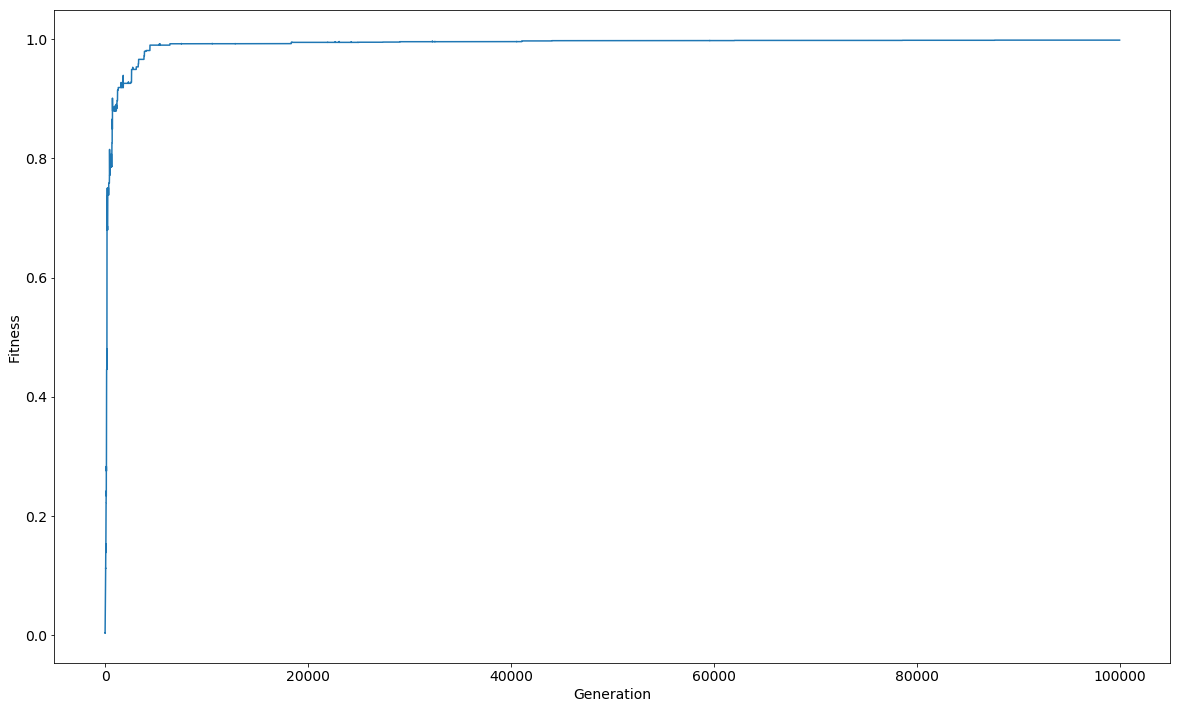

In [119]:
font = {'family' : 'normal',
        'weight' : 'light',
        'size'   : 14}

matplotlib.rc('font', **font)

plt.figure(figsize=(20,12))
plt.plot(range(len(fitness)-1),np.max(fitness,axis=1)[:-1])
plt.xlabel('Generation',font)
plt.ylabel('Fitness',font)
# plt.

In [116]:
simulateFCMp(C0,np.reshape(lastW[14],(7,6)),2),simulateFCMp(C0,W_init1,2)

(array([[0.47      , 0.51      , 0.13      , 0.        , 1.        ,
         0.37      , 0.1       ],
        [0.69930696, 0.6248064 , 0.61455402, 0.69951735, 0.73105887,
         0.59145901, 0.70119574]]),
 array([[0.47      , 0.51      , 0.13      , 0.        , 1.        ,
         0.37      , 0.1       ],
        [0.69930699, 0.62480647, 0.61455502, 0.69951723, 0.73105858,
         0.59145898, 0.70119608]]))

Text(763.7272727272725, 0.5, 'Edge pointing to')

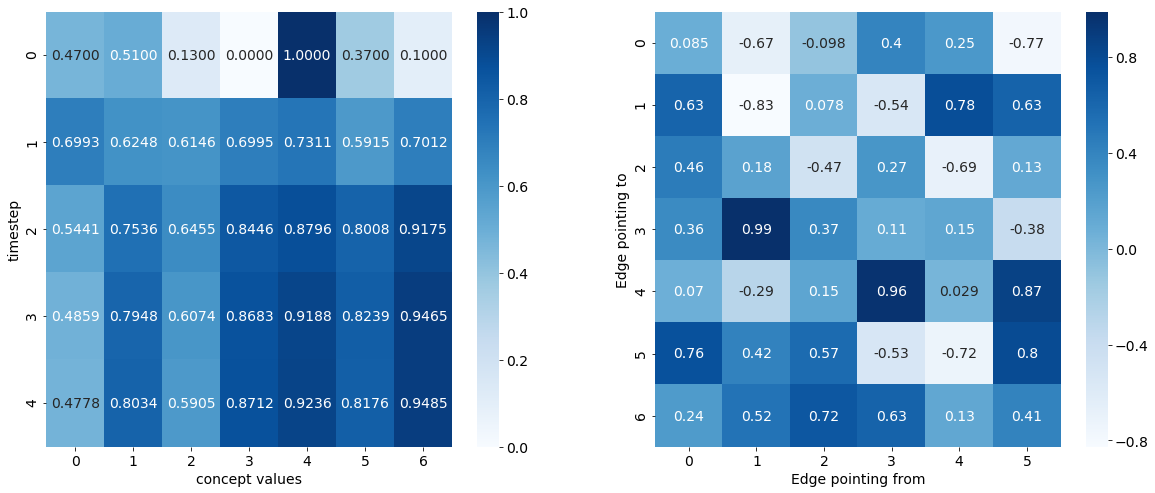

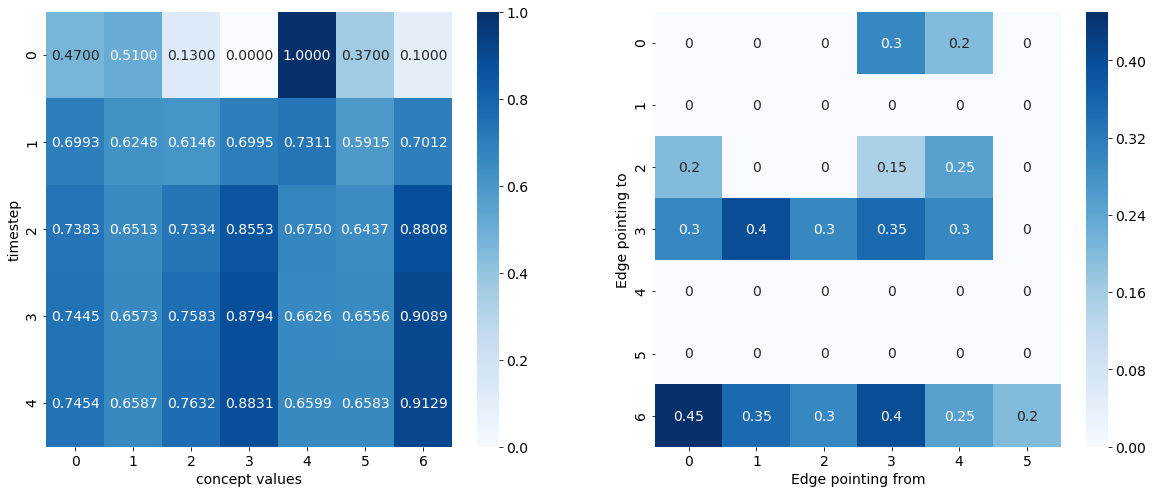

In [118]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.heatmap(simulateFCMp(C0,np.reshape(lastW[14],(7,6)),5),annot=True,cmap='Blues',fmt=".4f")
plt.xlabel('concept values')
plt.ylabel('timestep')
plt.subplot(1,2,2)
sns.heatmap(np.reshape(lastW[14],(7,6)),annot=True,cmap='Blues')
plt.xlabel('Edge pointing from')
plt.ylabel('Edge pointing to')



plt.figure(figsize=(20,8))
plt.title('Original')
plt.subplot(1,2,1)
sns.heatmap(simulateFCMp(C0,W_init1,5),annot=True,cmap='Blues',fmt=".4f")
plt.xlabel('concept values')
plt.ylabel('timestep')
plt.subplot(1,2,2)
sns.heatmap(np.reshape(W_init1,(7,6)),annot=True,cmap='Blues')
plt.xlabel('Edge pointing from')
plt.ylabel('Edge pointing to')

In [14]:
plt.plot(range(100000),fitness_plot)

NameError: name 'fitness_plot' is not defined

In [17]:
plt.figure()
lastW.shape

(100, 20)

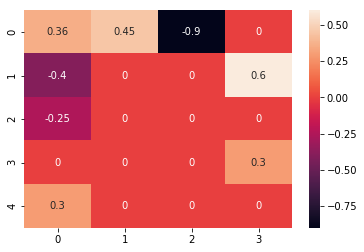

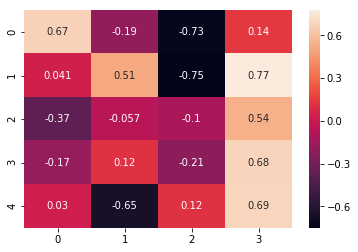

In [117]:
plt.figure()

sns.heatmap(W_init_nod,annot=True)
plt.figure()
sns.heatmap(np.reshape(lastW[0].T,(5,4)),annot=True)

In [72]:
a = list(np.random.choice([False, True], p=[1 - 0.05, 0.05],size=100).astype(int)*range(100))
a = list(filter(lambda x: x != 0, a))
print(a)

[18, 27, 40, 86, 88]


In [81]:
np.random.uniform(-1,1)

-0.8454881002574195

In [ ]:
300000-/100000

In [82]:
a = np.random.uniform(size=(20,10))

In [85]:
np.max(a,axis=1)

array([0.99815596, 0.84432526, 0.8465015 , 0.9534227 , 0.94789114,
       0.86539495, 0.9034129 , 0.8922318 , 0.87736696, 0.9981603 ,
       0.98569405, 0.99500098, 0.88948459, 0.75469327, 0.90614517,
       0.97656591, 0.95115287, 0.86504582, 0.90871842, 0.90981797])

In [87]:
max(a[1])

0.844325259985882